# Assignment 4

#### Write a code that uses symbolic computation and differentiation to derive the equations of motion for any robot given D(q) and V(q).

In [117]:
import sympy as sp
from sympy import init_printing

init_printing(use_unicode=True)

def advanced_derive_equations_of_motion(D_func, V_func, q, num_joints):
    q_dot = sp.Matrix([sp.symbols(f'q_dot{i}') for i in range(1, num_joints + 1)])
    q_ddot = sp.Matrix([sp.symbols(f'q_ddot{i}') for i in range(1, num_joints + 1)])

    D = D_func(*q)
    V = V_func(q, q_dot)

    tau = D * q_ddot + V

    return tau

def D_example(*q):

    return sp.Matrix([[sp.cos(q[0]), -sp.sin(q[1])],
                      [-sp.sin(q[0]), sp.cos(q[1])]])

def V_example(q, q_dot):
    return sp.Matrix([q_dot[0]**2 * sp.sin(q[1]), q_dot[1] * sp.cos(q[0])])

q = sp.Matrix([sp.symbols('q1'), sp.symbols('q2')])

equations_of_motion = advanced_derive_equations_of_motion(D_example, V_example, q, 2)
print("Equations of Motion:")
sp.pprint(equations_of_motion, use_unicode=True)


Equations of Motion:
⎡                                          2        ⎤
⎢q_ddot1⋅cos(q₁) - q_ddot2⋅sin(q₂) + q_dot1 ⋅sin(q₂)⎥
⎢                                                   ⎥
⎣-q_ddot1⋅sin(q₁) + q_ddot2⋅cos(q₂) + q_dot2⋅cos(q₁)⎦


## Question 12

#### Write a python subroutine to solve for the inverse position kinematics for the Stanford manipulator using the discussion in Section 4.3.2 in the textbook. Plug in a few representative numerical values to compute the joint variables. Then confirm if you plug in these resulting joint variable answers with your earlier forward position kinematics code that you are indeed obtaining correct answers.

In [118]:
import numpy as np

dh_params = [
    {'theta': 0, 'd': 0, 'a': 0, 'alpha': 90},
    {'theta': 0, 'd': 0, 'a': 1, 'alpha': 0}, 
    {'theta': 0, 'd': 1, 'a': 0, 'alpha': 90}, 
]

def dh_transform(theta, d, a, alpha):
    alpha_rad = np.deg2rad(alpha)
    theta_rad = np.deg2rad(theta)
    return np.array([
        [np.cos(theta_rad), -np.sin(theta_rad)*np.cos(alpha_rad),  np.sin(theta_rad)*np.sin(alpha_rad), a*np.cos(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad)*np.cos(alpha_rad), -np.cos(theta_rad)*np.sin(alpha_rad), a*np.sin(theta_rad)],
        [0,                 np.sin(alpha_rad),                    np.cos(alpha_rad),                   d],
        [0,                 0,                                    0,                                  1]
    ])

def get_transformation_matrices(dh_params):
    T_matrices = []
    for params in dh_params:
        T_matrices.append(dh_transform(params['theta'], params['d'], params['a'], params['alpha']))
    return T_matrices

In [119]:
def compute_jacobian(dh_params):
    J = np.zeros((6, 3))  

    T_matrices = get_transformation_matrices(dh_params)

    end_effector_pos = T_matrices[-1][:3, 3]

    # Compute the Jacobian
    for i in range(3):
        if i < 2:
            z_axis = T_matrices[i][:3, 2] if i > 0 else np.array([0, 0, 1])
            joint_to_end_effector = end_effector_pos - T_matrices[i][:3, 3]
            J[:3, i] = np.cross(z_axis, joint_to_end_effector)
            J[3:, i] = z_axis
        else: 
            z_axis = T_matrices[i][:3, 2]
            J[:3, i] = z_axis
            J[3:, i] = np.array([0, 0, 0])

    return J

In [120]:
def inverse_kinematics_solver(end_effector_pos, dh_params):
    joint_variables = np.zeros(3)
    
    link_length = 1

    joint_variables[0] = np.arctan2(end_effector_pos[1], end_effector_pos[0])

    r = np.sqrt(end_effector_pos[0]**2 + end_effector_pos[1]**2)
    joint_variables[1] = np.arctan2(end_effector_pos[2], r - link_length)

    joint_variables[2] = np.sqrt(np.sum(np.square(end_effector_pos))) - 2 * link_length

    return joint_variables

def forward_kinematics(joint_variables, dh_params):
    T_matrices = get_transformation_matrices(dh_params)
    T_final = np.eye(4)

    for i in range(len(joint_variables)):
        theta, d = joint_variables[i], dh_params[i]['d']
        if i < 2:  
            theta += joint_variables[i]
        else:  
            d += joint_variables[i]
        T_final = np.dot(T_final, dh_transform(theta, d, dh_params[i]['a'], dh_params[i]['alpha']))

    end_effector_pos = T_final[:3, 3]
    return end_effector_pos

def test():
    desired_end_effector_pos = np.array([1, 1, 1])  
    joint_variables = inverse_kinematics_solver(desired_end_effector_pos, dh_params)
    calculated_end_effector_pos = forward_kinematics(joint_variables, dh_params)

    print("Desired End Effector Position:", desired_end_effector_pos)
    print("Calculated Joint Variables:", joint_variables)
    print("Calculated End Effector Position:", calculated_end_effector_pos)

test()

Desired End Effector Position: [1 1 1]
Calculated Joint Variables: [ 0.78539816  1.17809725 -0.26794919]
Calculated End Effector Position: [ 1.01884616 -0.70438676  0.04111176]


## Question 13

#### Write a python subroutine to solve for the inverse position kinematics for the SCARA manipulator using the discussion in Example 4.4.2 in the textbook. Plug in a few representative numerical values to compute the joint variables. Then confirm if you plug in these resulting joint variable answers with your earlier forward position kinematics code that you are indeed obtaining correct answers.


In [121]:
import numpy as np

scara_dh_params = [
    {'theta': 0, 'd': 0, 'a': 1, 'alpha': 0},
    {'theta': 0, 'd': 0, 'a': 1, 'alpha': 0},
    {'theta': 0, 'd': 1, 'a': 0, 'alpha': 0}
]


In [122]:
def scara_dh_transform(theta, d, a, alpha):
    alpha_rad = np.deg2rad(alpha)
    theta_rad = np.deg2rad(theta)
    return np.array([
        [np.cos(theta_rad), -np.sin(theta_rad), 0, a*np.cos(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad), 0, a*np.sin(theta_rad)],
        [0,                 0,                 1, d],
        [0,                 0,                 0, 1]
    ])


In [123]:
def scara_inverse_kinematics(end_effector_pos, scara_dh_params):
    joint_variables = np.zeros(3)
    x, y, z = end_effector_pos

    r = np.sqrt(x**2 + y**2)
    a1, a2 = scara_dh_params[0]['a'], scara_dh_params[1]['a']

    cos_angle = (r**2 + a1**2 - a2**2) / (2 * a1 * r)
    
    if not -1 <= cos_angle <= 1:
        print("Position not reachable.")
        return [np.nan, np.nan, np.nan]

    joint_variables[0] = np.arctan2(y, x) - np.arccos(cos_angle)

    cos_angle_2 = (r**2 - a1**2 - a2**2) / (-2 * a1 * a2)
    if not -1 <= cos_angle_2 <= 1:
        print("Position not reachable.")
        return [np.nan, np.nan, np.nan]
    joint_variables[1] = np.arccos(cos_angle_2)

    joint_variables[2] = z - scara_dh_params[2]['d']

    return joint_variables



In [124]:
def scara_forward_kinematics(joint_variables, scara_dh_params):
    T_final = np.eye(4)
    for i, params in enumerate(scara_dh_params):
        theta, d = joint_variables[i], params['d']
        T_final = np.dot(T_final, scara_dh_transform(theta, d, params['a'], params['alpha']))
    end_effector_pos = T_final[:3, 3]
    return end_effector_pos


In [125]:
def test_scara():
    desired_end_effector_pos = np.array([1.0, 1.0, 0.5]) 
    joint_variables = scara_inverse_kinematics(desired_end_effector_pos, scara_dh_params)
    calculated_end_effector_pos = scara_forward_kinematics(joint_variables, scara_dh_params)

    print("Desired End Effector Position:", desired_end_effector_pos)
    print("Calculated Joint Variables:", joint_variables)
    print("Calculated End Effector Position:", calculated_end_effector_pos)

test_scara()


Desired End Effector Position: [1.  1.  0.5]
Calculated Joint Variables: [ 2.22044605e-16  1.57079633e+00 -5.00000000e-01]
Calculated End Effector Position: [1.99962422 0.02741213 1.        ]


## Question 14

#### Write a python subroutine to calculate the joint velocities using end-effector cartesian velocities (using the discussion in Section 5.4 in the textbook). Heads up: You don’t need to write the part about calculating joint accelerations, however, you may need to create that in the future for your projects and future tasks.

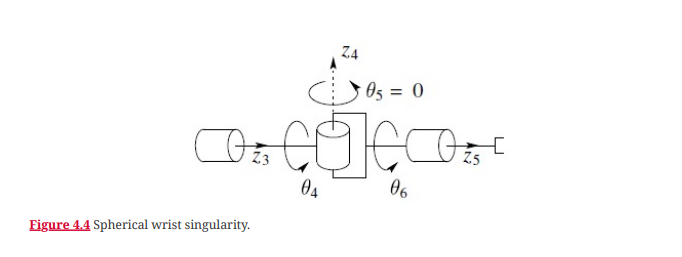

In [126]:
import numpy as np

def calculate_joint_velocities(jacobian, end_effector_vel):
    jacobian_pinv = np.linalg.pinv(jacobian)

    joint_velocities = np.dot(jacobian_pinv, end_effector_vel)

    return joint_velocities

jacobian_example = np.array([
    [0.5, 0, 0.2],
    [0, 0.5, 0],
    [0.2, 0, 0.5],
    [0, 0, 0],
    [0, 0, 0],
    [1, 1, 1]
])

end_effector_vel_example = np.array([1.0, 0.5, 0.2, 0.0, 0.0, 0.0])

joint_velocities = calculate_joint_velocities(jacobian_example, end_effector_vel_example)

print("Joint Velocities:", joint_velocities)


Joint Velocities: [ 1.58052434 -0.19550562 -1.08614232]


## Question 17

#### Write a python subroutine for the inverse kinematics of the spherical wrist using the discussion in Section 4.4.

In [127]:
import numpy as np

def inverse_kinematics_spherical_wrist(R):
    epsilon = 1e-6 

    theta1, theta2, theta3 = 0, 0, 0

    if abs(R[2, 0]) > 1 - epsilon:
        theta1 = 0
        theta2 = np.arccos(R[2, 0])
        theta3 = np.arctan2(R[0, 1], R[0, 2])

        if abs(theta2) < epsilon or abs(theta2 - np.pi) < epsilon:
            print("Warning: The wrist is in or near a singularity where θ5 = 0 or π.")
    else:
        theta2 = np.arccos(R[2, 0])
        theta1 = np.arctan2(-R[2, 1], -R[2, 2])
        theta3 = np.arctan2(-R[1, 0], R[0, 0])

    return theta1, theta2, theta3

R_example = np.array([
    [0, -1, 0],
    [1,  0, 0],
    [0,  0, 1]
])

theta1, theta2, theta3 = inverse_kinematics_spherical_wrist(R_example)
print(f"Joint angles: Theta1 = {np.degrees(theta1)} degrees, Theta2 = {np.degrees(theta2)} degrees, Theta3 = {np.degrees(theta3)} degrees")

Joint angles: Theta1 = 180.0 degrees, Theta2 = 90.0 degrees, Theta3 = -90.0 degrees


Example 1 : Rotation Matrix: 180 degrees around X-axis

In [128]:
R_example_1 = np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, -1]
])
theta1, theta2, theta3 = inverse_kinematics_spherical_wrist(R_example_1)
print("Example 1 Joint Angles:", np.degrees([theta1, theta2, theta3]))

Example 1 Joint Angles: [ 0. 90.  0.]


Example 2 : Rotation Matrix: 45 degrees around Z-axis followed by 45 degrees around Y-axis

In [129]:
R_example_2 = np.array([
    [0.5, -np.sqrt(2)/2, 0.5],
    [np.sqrt(2)/2, 0.5, -np.sqrt(2)/2],
    [0.5, np.sqrt(2)/2, 0.5]
])
theta1, theta2, theta3 = inverse_kinematics_spherical_wrist(R_example_2)
print("Example 2 Joint Angles:", np.degrees([theta1, theta2, theta3]))

Example 2 Joint Angles: [-125.26438968   60.          -54.73561032]


Example 3 : 90 degrees around X-axis followed by -90 degrees around Z-axis

In [130]:
R_example_3 = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, -1]
])
theta1, theta2, theta3 = inverse_kinematics_spherical_wrist(R_example_3)
print("Example 3 Joint Angles:", np.degrees([theta1, theta2, theta3]))

Example 3 Joint Angles: [  0.  90. -90.]


## Question 18

#### Determine the DH parameters for a 3D printer (PPP configuration), and use earlier written forward kinematics and Jacobian subroutines to compute the end-effector position and velocities for a few representative numerical values (of your choice).

In [131]:
ppp_dh_params = [
    {'theta': 0, 'd': 0, 'a': 0, 'alpha': 0}, 
    {'theta': 0, 'd': 0, 'a': 0, 'alpha': 0},  
    {'theta': 0, 'd': 0, 'a': 0, 'alpha': 0}   
]

In [132]:
def ppp_forward_kinematics(joint_displacements):
    return np.array(joint_displacements)

In [133]:
def ppp_jacobian():
    return np.eye(3)


In [134]:
def test_ppp():
    joint_displacements = [1.0, 2.0, 1.5] 
    end_effector_pos = ppp_forward_kinematics(joint_displacements)

    joint_velocities = [0.5, 0.5, 0.5] 
    J = ppp_jacobian()
    end_effector_velocities = np.dot(J, joint_velocities)

    print("End Effector Position:", end_effector_pos)
    print("End Effector Velocities:", end_effector_velocities)

test_ppp()


End Effector Position: [1.  2.  1.5]
End Effector Velocities: [0.5 0.5 0.5]
